In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [58]:
class Likelihood(nn.Module):
    def __init__(self):
        super().__init__()
        # Parameters for line
        self.m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Noise of data
        self.noise = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Collect losses over time
        self.losses = []
    
    def forward(self, x, y):
        # Takes numpy array as input and converts to tensors
        x = torch.tensor(x)
        y = torch.tensor(y)
        
        # Minimizing this function
        loss = (1 / len(x)) * torch.sum((y - x * self.m - self.b) ** 2 / (2 * self.noise ** 2)) + torch.log(self.noise)
        
        # Save and return loss
        self.losses.append(loss.item())
        return loss

In [59]:
class SimpleProb(nn.Module):
    def __init__(self):
        super().__init__()
        self.std = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # Collects loss over time
        self.losses = []
    
    def forward(self, k):
        loss = torch.log(self.std) + 0.5 * (k / self.std) ** 2
    
        # Save and return loss
        self.losses.append(loss.item())
        return loss

In [60]:
class Posterior(nn.Module):
    def __init__(self):
        # All parameters that need optimization
        super().__init__()
        self.ll = Likelihood()
        self.pm = SimpleProb()
        self.pb = SimpleProb()
        
        # Collects loss over time
        self.losses = []
        self.reses = []
    
    def forward(self, x, y):
        loss = -torch.log(self.ll(x, y) * self.pm(self.ll.m) * self.pb(self.ll.b))
        self.reses.append((self.ll.m.item(), self.pm.std.item(), self.ll.b.item(), self.pb.std.item(), self.ll.noise.item()))
        
        # Save and return loss
        self.losses.append(loss.item())
        return loss
    

In [61]:
def train(model, x, y, epochs=5, frac=0.1):
    optimizer = optim.Adam(model.parameters())
    
    for epoch in tqdm(range(epochs), desc="Training..."):
        # Zero gradiant for training
        optimizer.zero_grad()
        
        # Random selection of data points per iteration
        indices = np.random.randint(low=0, high=len(x), size=int(len(x) * frac))
        
        # Calculates likelihood
        loglik = model(x[indices], y[indices])
        e = torch.mean(loglik)
        
        # Updates parameters
        e.backward()
        optimizer.step()
    
    return model

In [62]:
df = pd.read_csv('data/Advertising.csv').drop('Unnamed: 0', axis=1)
x = df.TV.to_numpy()
y = df.Sales.to_numpy()

In [63]:
model_ll = train(Likelihood(), x, y, epochs=5000)
model_ll

Training...: 100%|██████████| 5000/5000 [00:03<00:00, 1287.82it/s]


Likelihood()

In [64]:
(model_ll.m, model_ll.b, model_ll.noise)

(Parameter containing:
 tensor(0.0815, requires_grad=True),
 Parameter containing:
 tensor(0.2944, requires_grad=True),
 Parameter containing:
 tensor(1.4848, requires_grad=True))

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Likelihood Loss')]

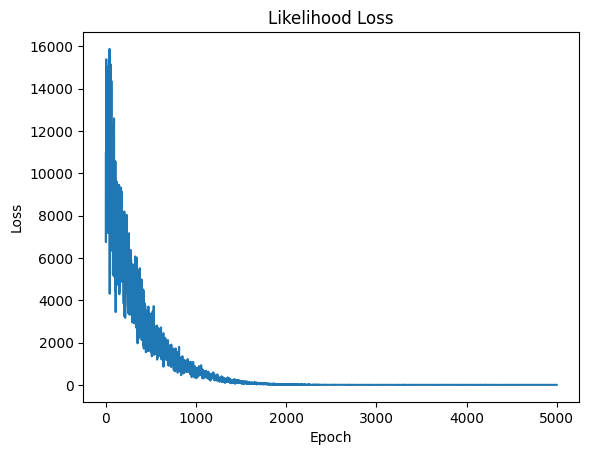

In [65]:
fig = sns.lineplot(x=range(len(model_ll.losses)), y=model_ll.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Likelihood Loss')

In [66]:
model_pl = train(Posterior(), x, y, epochs=5000)
model_pl

Training...: 100%|██████████| 5000/5000 [00:06<00:00, 806.64it/s]


Posterior(
  (ll): Likelihood()
  (pm): SimpleProb()
  (pb): SimpleProb()
)

In [67]:
(model_pl.ll.m, model_pl.pm.std, model_pl.ll.b, model_pl.pb.std, model_pl.ll.noise, model_pl.pm.std)

(Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor(nan, requires_grad=True))

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Posterior Loss')]

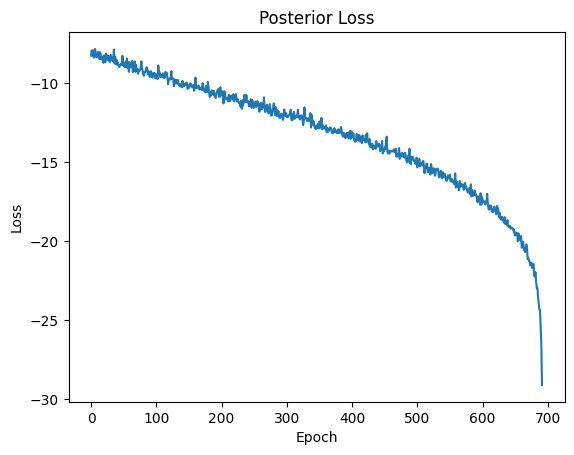

In [68]:
fig = sns.lineplot(x=range(len(model_ll.losses)), y=model_pl.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Posterior Loss')

In [69]:
model_pl.reses

[(1.0, 1.0, 1.0, 1.0, 1.0),
 (1.0010000467300415,
  0.9990000128746033,
  1.0010000467300415,
  0.9990000128746033,
  0.9990000128746033),
 (1.002000093460083,
  0.9980000853538513,
  1.0019999742507935,
  0.9980000853538513,
  0.9979999661445618),
 (1.0029999017715454,
  0.9970002770423889,
  1.0029997825622559,
  0.9970002770423889,
  0.9969999194145203),
 (1.0039997100830078,
  0.9960006475448608,
  1.0039994716644287,
  0.9960006475448608,
  0.995999813079834),
 (1.0049992799758911,
  0.9950012564659119,
  1.004998803138733,
  0.9950012564659119,
  0.9949995875358582),
 (1.005998969078064,
  0.9940021634101868,
  1.005997896194458,
  0.9940021634101868,
  0.9939993023872375),
 (1.0069985389709473,
  0.9930033683776855,
  1.006996750831604,
  0.9930033683776855,
  0.9929988980293274),
 (1.0079976320266724,
  0.9920049905776978,
  1.0079952478408813,
  0.9920049905776978,
  0.9919983744621277),
 (1.0089964866638184,
  0.9910070300102234,
  1.0089932680130005,
  0.9910070300102234,
  

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Posterior Loss')]

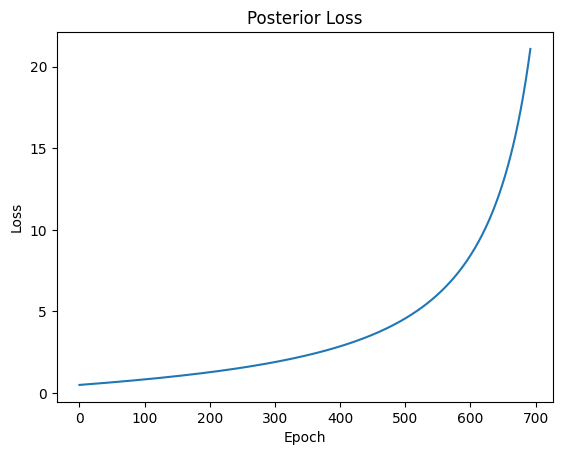

In [70]:
fig = sns.lineplot(x=range(len(model_pl.pm.losses)), y=model_pl.pm.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Posterior Loss')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'), Text(0.5, 1.0, 'Posterior Loss')]

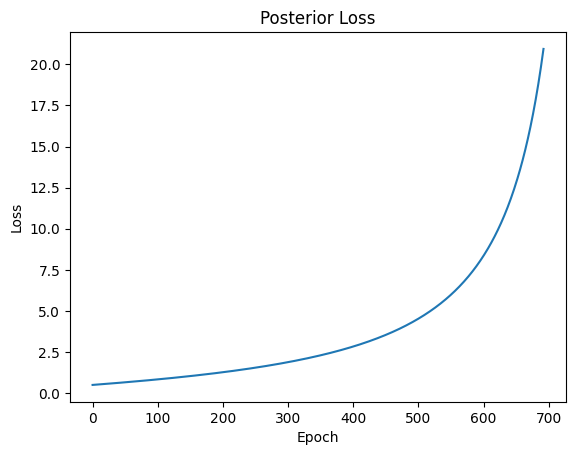

In [71]:
fig = sns.lineplot(x=range(len(model_pl.pb.losses)), y=model_pl.pb.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Posterior Loss')